In [1]:
import pandas as pd
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('process_csv_stage_3.csv')
df

,old_index,preprocessed_text,topic_lda,priority
0,1,good morning name appreciate could help put st...,0,3
1,2,upgraded card tell agent upgrade anniversary d...,3,1
2,10,chase card report however fraudulent applicati...,6,2
3,11,try book ticket come across offer apply toward...,3,3
4,14,grand son give check deposit chase account fun...,4,3
...,...,...,...,...
21067,78303,chase card customer well decade offer multiple...,3,3
21068,78309,wednesday call chas visa credit card provider ...,8,1
21069,78310,familiar pay understand great risk provide con...,2,2
21070,78311,flawless credit chase credit card chase freedo...,7,3


# Data Partition

In [3]:
# deal with class imbalance: oversampling for ticket priority
class_counts = df['priority'].value_counts()
class_weights = len(class_counts)/class_counts
df = df.sample(
    n=class_counts.max()*len(class_counts),
    weights=df['priority'].map(class_weights), 
    replace=True,
    random_state=42)
df.value_counts('priority')

priority
2    10634
3    10488
1    10486
Name: count, dtype: int64

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = df['preprocessed_text']

vectorizer = TfidfVectorizer(
    max_df=0.8,
    min_df=0.05,
    max_features=10000
)
X = vectorizer.fit_transform(corpus)
X.shape

(31608, 301)

In [5]:
vectorizer.get_feature_names_out()

array(['able', 'accept', 'access', 'account', 'act', 'action', 'activity',
       'add', 'additional', 'address', 'advise', 'agency', 'ago', 'agree',
       'allow', 'already', 'also', 'amount', 'another', 'answer',
       'anything', 'appear', 'application', 'apply', 'approve', 'around',
       'ask', 'attach', 'attempt', 'attorney', 'authorize', 'available',
       'away', 'back', 'balance', 'bank', 'banking', 'base', 'begin',
       'believe', 'bill', 'branch', 'bureau', 'business', 'call',
       'cancel', 'card', 'case', 'cash', 'cause', 'cfp', 'change',
       'charge', 'check', 'claim', 'clear', 'clearly', 'close', 'come',
       'company', 'complaint', 'complete', 'concern', 'confirm',
       'consumer', 'contact', 'continue', 'copy', 'correct', 'could',
       'credit', 'current', 'customer', 'date', 'day', 'debit', 'debt',
       'decide', 'deny', 'department', 'deposit', 'different', 'dispute',
       'document', 'documentation', 'dollar', 'due', 'either', 'email',
       'e

In [6]:
y = df[['topic_lda','priority']]

In [7]:
# split into training set (test set?) and validation set

# train = 80, test = 20
# random_seed = 42
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# y1 = df['topic_lda']
# y2 = df['priority']

# X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.2, random_state=42)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
# print(y1_train.shape)
# print(y1_test.shape)
# print(y2_train.shape)
# print(y2_test.shape)

(25286, 301)
(6322, 301)
(25286, 2)
(6322, 2)


# Model Building

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [11]:
rf_preds = rf.predict(X_test)
rf_preds

array([[0, 1],
       [4, 2],
       [2, 3],
       ...,
       [6, 3],
       [0, 1],
       [0, 2]], dtype=int64)

In [12]:
Y_test = y_test.to_numpy()

In [13]:
print("Best model accuracy:", np.mean(np.all(Y_test == rf_preds, axis=1)))

Best model accuracy: 0.8513128756722557


In [14]:
rf_preds[:, 0]

array([0, 4, 2, ..., 6, 0, 0], dtype=int64)

In [15]:
rf_preds[:, 1]

array([1, 2, 3, ..., 3, 1, 2], dtype=int64)

# Evaluation

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

================ Ticket Category =================
Accuracy:  0.9253400822524518
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      1333
           1       0.92      0.94      0.93       712
           2       0.97      0.80      0.88       319
           3       0.87      0.88      0.88       452
           4       0.91      0.97      0.94      1015
           5       0.96      0.91      0.94       511
           6       0.91      0.93      0.92       646
           7       0.95      0.93      0.94       702
           8       0.96      0.91      0.93       632

    accuracy                           0.93      6322
   macro avg       0.93      0.91      0.92      6322
weighted avg       0.93      0.93      0.93      6322



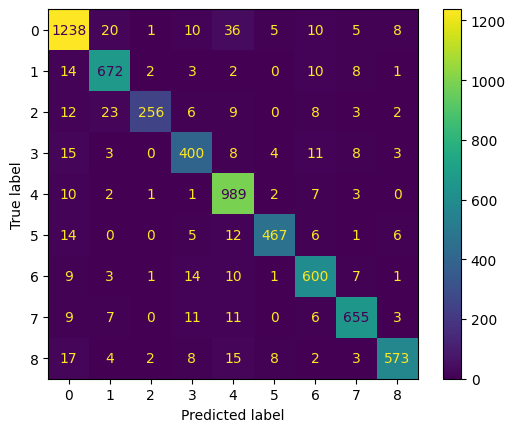

In [17]:
print(f'{" Ticket Category ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['topic_lda'], y_pred=rf_preds[:, 0]))
print("Classification Report:\n",classification_report(y_test['topic_lda'], rf_preds[:, 0]))

cm = confusion_matrix(y_true=y_test['topic_lda'], y_pred=rf_preds[:, 0])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(9)])
cm_display.plot()
plt.show()

================ Ticket Priority =================
Accuracy:  0.8935463460930085
Classification Report:
               precision    recall  f1-score   support

           1       0.92      0.93      0.92      2098
           2       0.87      0.89      0.88      2126
           3       0.90      0.87      0.88      2098

    accuracy                           0.89      6322
   macro avg       0.89      0.89      0.89      6322
weighted avg       0.89      0.89      0.89      6322



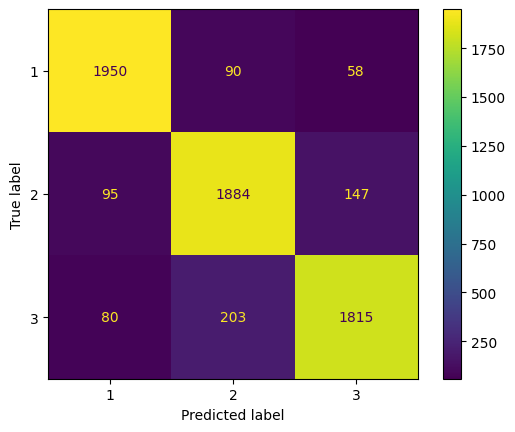

In [18]:
print(f'{" Ticket Priority ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['priority'], y_pred=rf_preds[:, 1]))
print("Classification Report:\n",classification_report(y_test['priority'], rf_preds[:, 1]))

cm = confusion_matrix(y_true=y_test['priority'], y_pred=rf_preds[:, 1])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(1,4)])
cm_display.plot()
plt.show()

# Tuning

In [19]:
from sklearn.model_selection import RandomizedSearchCV

In [20]:
param_grid = {
    "n_estimators": np.linspace(100,1000, 10).astype(int),
    "min_samples_split": np.linspace(0.01, 0.05, 5),
    "min_samples_leaf": np.linspace(0.005, 0.025, 5),
    "max_depth":[10,20,50],
    "max_leaf_nodes":[5,10,50,100]
}

In [21]:
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
    param_distributions=param_grid, 
    n_iter=100,
    cv=5, 
    n_jobs=-1, 
    verbose=2)

In [22]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 50],
                                        'max_leaf_nodes': [5, 10, 50, 100],
                                        'min_samples_leaf': array([0.005, 0.01 , 0.015, 0.02 , 0.025]),
                                        'min_samples_split': array([0.01, 0.02, 0.03, 0.04, 0.05]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
                   verbose=2)

In [23]:
print("Best hyperparameters:", random_search.best_params_)

Best hyperparameters: {'n_estimators': 700, 'min_samples_split': 0.03, 'min_samples_leaf': 0.025, 'max_leaf_nodes': 50, 'max_depth': 20}


In [24]:
bestrf = random_search.best_estimator_

In [25]:
bestrf_preds = bestrf.predict(X_test)
best_rf_score = np.mean(np.all(Y_test == bestrf_preds, axis=1))
print("Best model accuracy:", best_rf_score)

Best model accuracy: 0.29120531477380573


# Evaluation After Tuning

================ Ticket Category =================
Accuracy:  0.5439734261309712
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.82      0.54      1333
           1       0.66      0.74      0.70       712
           2       0.00      0.00      0.00       319
           3       0.84      0.08      0.15       452
           4       0.60      0.82      0.69      1015
           5       0.83      0.02      0.04       511
           6       0.61      0.74      0.67       646
           7       0.80      0.35      0.49       702
           8       0.70      0.33      0.45       632

    accuracy                           0.54      6322
   macro avg       0.61      0.43      0.41      6322
weighted avg       0.61      0.54      0.49      6322



C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


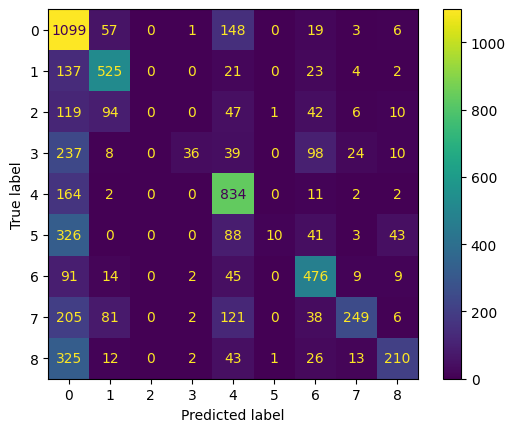

In [26]:
print(f'{" Ticket Category ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['topic_lda'], y_pred=bestrf_preds[:, 0]))
print("Classification Report:\n",classification_report(y_test['topic_lda'], bestrf_preds[:, 0]))

cm = confusion_matrix(y_true=y_test['topic_lda'], y_pred=bestrf_preds[:, 0])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(9)])
cm_display.plot()
plt.show()

================ Ticket Priority =================
Accuracy:  0.5480860487187599
Classification Report:
               precision    recall  f1-score   support

           1       0.54      0.64      0.59      2098
           2       0.50      0.51      0.50      2126
           3       0.62      0.50      0.55      2098

    accuracy                           0.55      6322
   macro avg       0.55      0.55      0.55      6322
weighted avg       0.55      0.55      0.55      6322



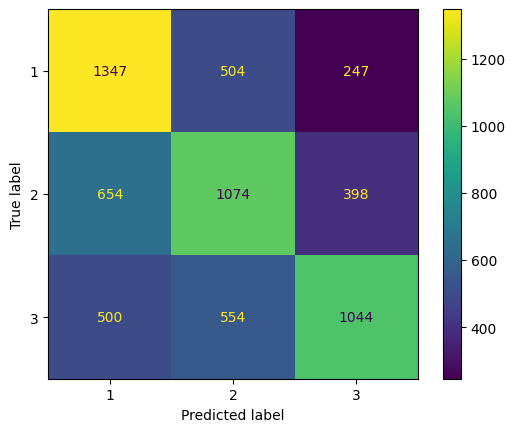

In [27]:
print(f'{" Ticket Priority ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['priority'], y_pred=bestrf_preds[:, 1]))
print("Classification Report:\n",classification_report(y_test['priority'], bestrf_preds[:, 1]))

cm = confusion_matrix(y_true=y_test['priority'], y_pred=bestrf_preds[:, 1])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(1,4)])
cm_display.plot()
plt.show()

# Save tuned model to disk

In [28]:
import os
from pickle import dump
with open(os.path.join(os.getcwd(),'ml_models',"tuned_rf_single.pkl"), "wb") as f:
    dump(bestrf, f, protocol=5)